In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
#funcion conv para pasar tiempo de redshift a Gyr
import numpy as np

def conv(z, h, omega_lambda, omega_matter):

    H0=100*h
#conversion Mpc --> km
    conv1=1./(1e6*206265*1.496e8)
#conversion de s --> Gyr
    conv2=3600*24*365.25*1e9
    H0=H0*conv1*conv2

    c1=np.sqrt(omega_lambda*(1.+z)**(-3.))+np.sqrt((omega_lambda*(1.+z)**(-3.))+omega_matter)
    ln=np.log(c1/np.sqrt(omega_matter))
    c2=2./(3.*np.sqrt(omega_lambda))
        
    time = (1./H0)*c2*ln

    return time

In [4]:
# Vamos a calcular los valores de A2max y krot para los distintos tiempos
#t, A2max, krot, Mgal, Mgas, Mvir 
#calculamos los parámetros de las galaxias 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength as strng
import kapparot as krot
import time_conversion as tiempo

#fo=open('/home/ornela/python/sem2/parametros2.dat','w')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

atime = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = atime[:,2]

vector = ('00','01','03')

snapshot=range(496,50,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    #for i in range(0,1):
        #fo =open('/home/ornela/python/sem2/A2-krot-s'+'%s' %vector[i]+'.dat','a')
    fo =open('/home/ornela/python/barra/param_time-M31.dat','a')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value

    pgas = snap['subhalo_000/Gas/Coordinates'].value
    masa_gas = snap['subhalo_000/Gas/Masses'].value

    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    masa_drk = snap['subhalo_000/Drk/Masses'].value

    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] *aexp[isnap] + Ht *xstr/1000.
    v_y = vel[:,1] *aexp[isnap] + Ht *ystr/1000.
    v_z = vel[:,2] *aexp[isnap] + Ht *zstr/1000.

#----------------------masas----------------------------
    masa_str = masa_str/h
    masa_gas = masa_gas/h
    masa_drk = masa_drk/h

    r200 = r200*aexp[isnap]/h

    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    limit_gas = np.where(rgas<rgal)
    rgas_sort = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    limit_drk = np.where(rdrk<r200)
    rdrk_sort = np.sort(rdrk[limit_drk])
    rdrk_indice = np.argsort(rdrk[limit_drk])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

    Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
    M_gas = Mc_gas[-1]

    Mc_drk = cumsum((masa_drk[limit_drk])[rdrk_indice])
    M_drk = Mc_drk[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------
    rvir= concatenate([r,rgas,rdrk])
    mvir= concatenate([masa_str, masa_gas, masa_drk])

    limit_vir = np.where(rvir<r200)
    rvir_sort = np.sort(rvir[limit_vir])
    rvir_indice = np.argsort(rvir[limit_vir])

    Mc_vir = cumsum((mvir[limit_vir])[rvir_indice])

    M_vir = Mc_vir[-1]

#-------------------------------------------------------------------            
    corte1,=np.where(r<r90[-1])
    corte2,=np.where(r<2*r50[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    A2max, rmax, phi = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)

    k_rot = krot.kapa(masa_str[corte1], xn[corte1], yn[corte1], zn[corte1],
                     vxn[corte1], vyn[corte1], vzn[corte1])

    fo.write(str('%.6f'% t) +'\t'+
             str('%12.6f'% r50[-1]) +'\t'+
             str('%12.6f'% rgal) +'\t'+
             str('%12.6f'% r200) +'\t'+
             str('%12.6f'% A2max) +'\t'+
             str('%12.6f'% phi) +'\t'+ 
             str('%12.6f'% k_rot)+'\t'+
             str('%12.6f'% log10(M_gal*1e10)) +'\t'+
             str('%12.6f'% log10(M_gas*1e10)) +'\t'+
             str('%12.6f'% log10(M_vir*1e10)) +'\t'+
             str('%12.6f'% log10(M_drk*1e10)) +'\n')
    fo.close()


/home/ornela/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/ornela/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
barstrength.py:16: RuntimeWarning: invalid value encountered in greater
  kk,=np.where((rcil>rbin[j-1]) & (rcil<=rbin[j]))
barstrength.py:16: RuntimeWarning: invalid value encountered in less_equal
  kk,=np.where((rcil>rbin[j-1]) & (rcil<=rbin[j]))
barstrength.py:27: RuntimeWarning: invalid value encountered in double_scalars
  A2v[j]=np.sqrt(a2**2+b2**2)/a0
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in float_scalars
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:131: RuntimeWarning: invalid value encountered in float_scalars
/home/ornela/anaconda2

IndexError: index -1 is out of bounds for axis 0 with size 0

In [37]:
aux=range(497,50,-1)
len(aux)

447

In [7]:
# Vamos a calcular los valores de A2max y krot para los distintos tiempos
#t, A2max, krot, Mgal, Mgas, Mvir 
#calculamos los parámetros de las galaxias 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength as strng
import kapparot as krot
import time_conversion as tiempo
import furier_components as fc

#fo=open('/home/ornela/python/sem2/parametros2.dat','w')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

atime = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = atime[:,2]

vector = ('00','01','03')

snapshot=range(496,50,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    #for i in range(0,1):
        #fo =open('/home/ornela/python/sem2/A2-krot-s'+'%s' %vector[i]+'.dat','a')
    fo =open('/home/ornela/python/barra/a2b2_time-M31.dat','a')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value

    pgas = snap['subhalo_000/Gas/Coordinates'].value
    masa_gas = snap['subhalo_000/Gas/Masses'].value

    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    masa_drk = snap['subhalo_000/Drk/Masses'].value

    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] *aexp[isnap] + Ht *xstr/1000.
    v_y = vel[:,1] *aexp[isnap] + Ht *ystr/1000.
    v_z = vel[:,2] *aexp[isnap] + Ht *zstr/1000.

#----------------------masas----------------------------
    masa_str = masa_str/h
    masa_gas = masa_gas/h
    masa_drk = masa_drk/h

    r200 = r200*aexp[isnap]/h

    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]           

#------------------masa total en r200 (Mvir)--------------------------
    corte1,=np.where(r<r90[-1])
    corte2,=np.where(r<2*r50[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    a2, b2, rmax = fc.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)

    fo.write(str('%.6f'% t) +'\t'+
             str('%12.6f'% a2) +'\t'+
             str('%12.6f'% b2) +'\n')
    fo.close()

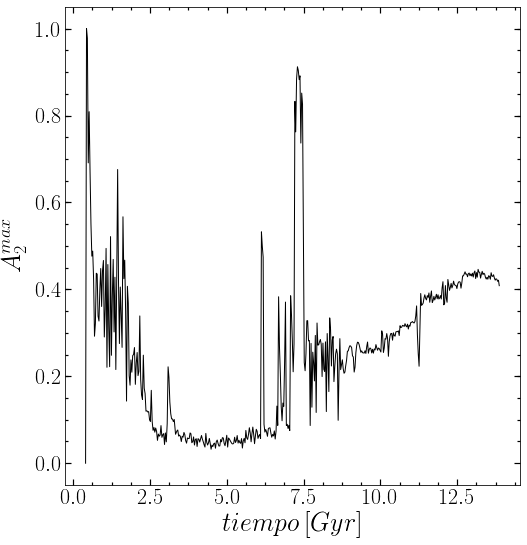

In [22]:
#A2max vs tiempo
import matplotlib.pyplot as plt
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

cm=np.loadtxt('/home/ornela/python/barra/param_time-M31.dat')

t=cm[:,0]
A2max=cm[:,4]

time =[]
A2=[]
aux=range(0,len(t)-1,1)
for j in aux:
    time.append(t[j])
    A2.append(A2max[j])

fig = plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax0=fig.add_subplot(111)
ax0.plot(time,A2,'k', lw=1)
#ax0.set_ylim(0,1)
#ax0.set_xlim(2,14)
ax0.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=26)
ax0.set_ylabel(r'$A_{2}^{max}$', fontsize=26)
ax0.minorticks_on()
ax0.tick_params( labelsize=22)
ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

plt.show()

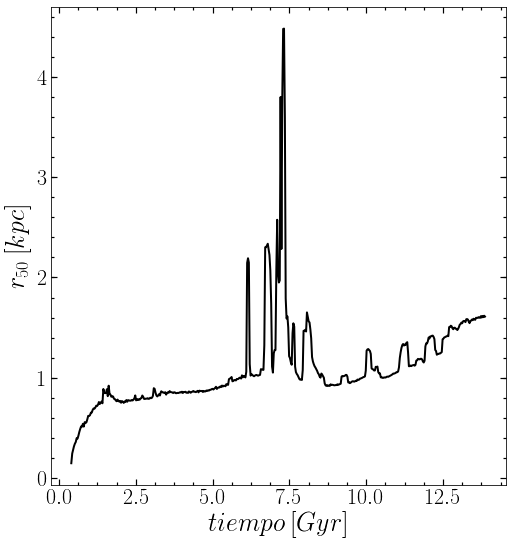

In [28]:
#r50 vs tiempo
import matplotlib.pyplot as plt
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

cm=np.loadtxt('/home/ornela/python/barra/param_time-M31.dat')

t=cm[:,0]
r50=cm[:,1]

time =[]
r_50=[]
aux=range(0,len(t)-1,1)
for j in aux:
    time.append(t[j])
    r_50.append(r50[j])

fig = plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax0=fig.add_subplot(111)
ax0.plot(time,r_50,'k', lw=2)
#ax0.set_ylim(0,1)
#ax0.set_xlim(2,14)
ax0.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=26)
ax0.set_ylabel(r'$r_{50}\:[kpc]$', fontsize=26)
ax0.minorticks_on()
ax0.tick_params( labelsize=22)
ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

plt.show()

In [7]:
print r50

[ 0.0026682   0.00596628  0.0084376  ...,  1.61053658  1.61053884
  1.61058962]


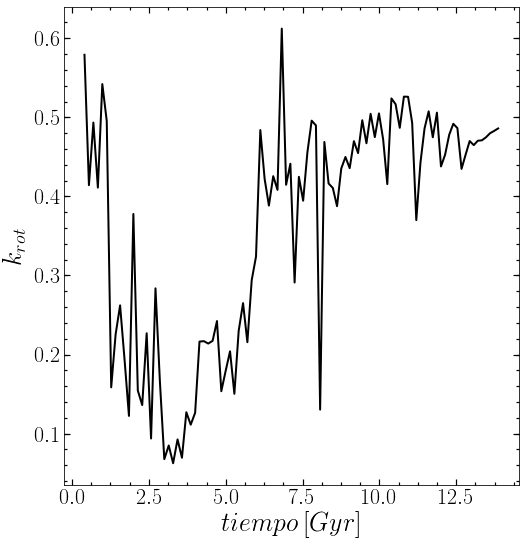

In [33]:
#krot vs tiempo
import matplotlib.pyplot as plt
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

cm=np.loadtxt('/home/ornela/python/barra/param_time-M31.dat')

t=cm[:,0]
krot=cm[:,6]

time =[]
k_rot=[]
aux=range(0,len(t)-1,5)
for j in aux:
    time.append(t[j])
    k_rot.append(krot[j])

fig = plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax0=fig.add_subplot(111)
ax0.plot(time,k_rot,'k', lw=2)
#ax0.set_ylim(0,1)
#ax0.set_xlim(2,14)
ax0.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=26)
ax0.set_ylabel(r'$k_{rot}$', fontsize=26)
ax0.minorticks_on()
ax0.tick_params( labelsize=22)
ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

plt.show()

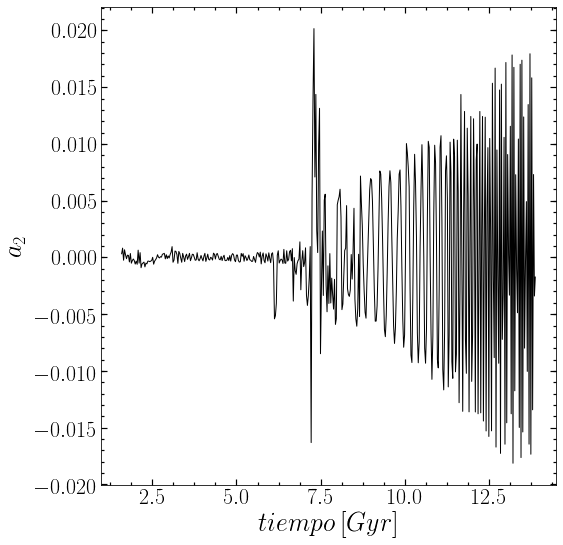

In [40]:
#a2 vs tiempo
import matplotlib.pyplot as plt
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

cm=np.loadtxt('/home/ornela/python/barra/a2b2_time-M31.dat')

t=cm[:,0]
a2=cm[:,1]

time =[]
a_2=[]
aux=range(0,len(t)-1,1)
for j in aux:
    time.append(t[j])
    a_2.append(a2[j])

fig = plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax0=fig.add_subplot(111)
ax0.plot(time,a_2,'k', lw=1)
#ax0.set_ylim(0,1)
#ax0.set_xlim(7,10)
ax0.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=26)
ax0.set_ylabel(r'$a_2$', fontsize=26)
ax0.minorticks_on()
ax0.tick_params( labelsize=22)
ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

plt.show()

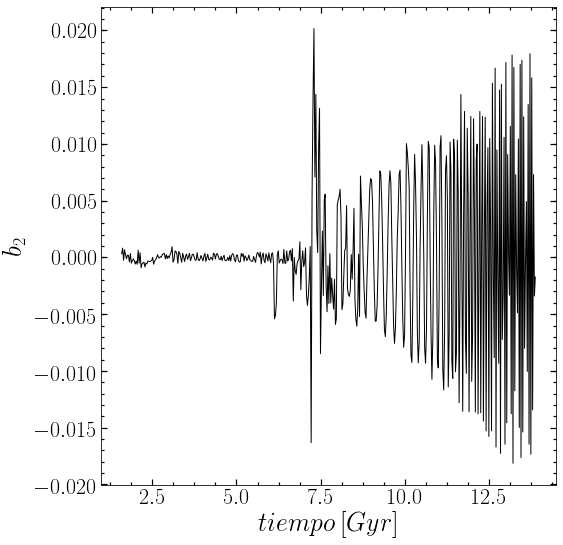

In [38]:
#a2 vs tiempo
import matplotlib.pyplot as plt
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

cm=np.loadtxt('/home/ornela/python/barra/a2b2_time-M31.dat')

t=cm[:,0]
b2=cm[:,2]

time =[]
b_2=[]
aux=range(0,len(t)-1,1)
for j in aux:
    time.append(t[j])
    b_2.append(b2[j])

fig = plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax0=fig.add_subplot(111)
ax0.plot(time,a_2,'k', lw=1)
#ax0.set_ylim(0,1)
#ax0.set_xlim(2,14)
ax0.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=26)
ax0.set_ylabel(r'$b_2$', fontsize=26)
ax0.minorticks_on()
ax0.tick_params( labelsize=22)
ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

plt.show()

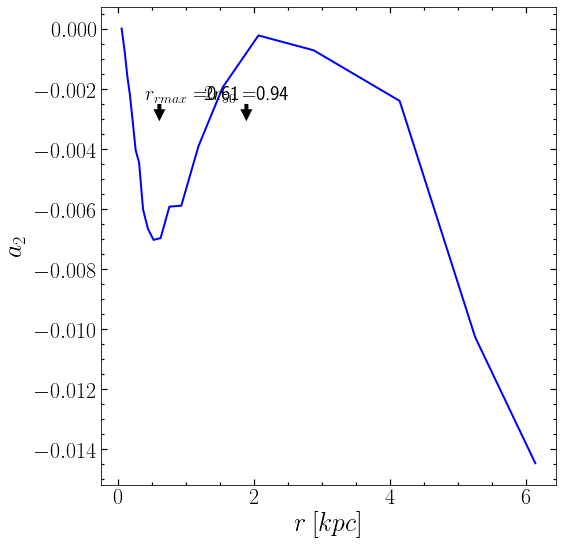

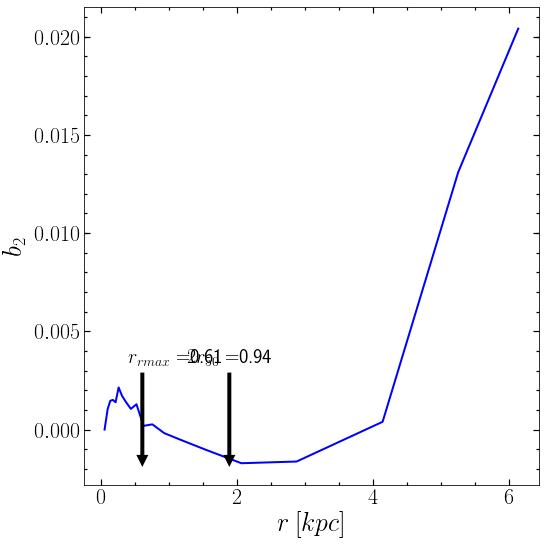

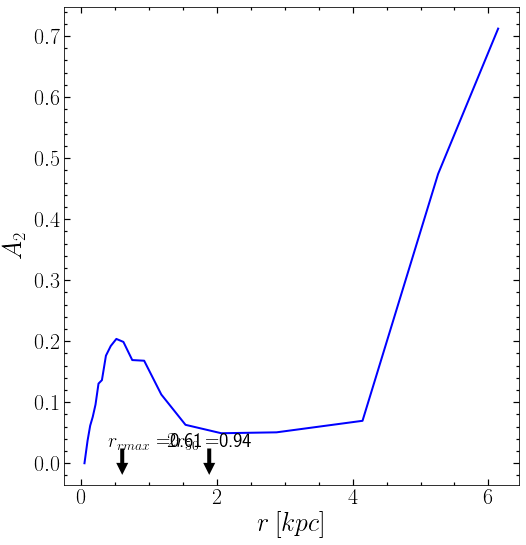

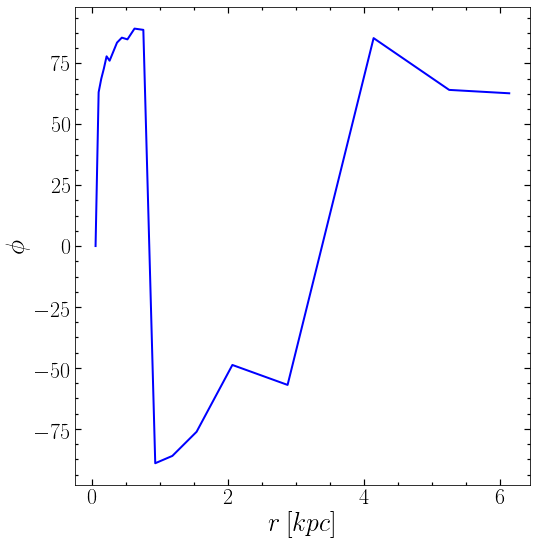

In [59]:
# Vamos a calcular los valores de A2max y krot para los distintos tiempos
#t, A2max, krot, Mgal, Mgas, Mvir 
#calculamos los parámetros de las galaxias 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength as strng
import kapparot as krot
import time_conversion as tiempo
import furier_components as fc
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#fo=open('/home/ornela/python/sem2/parametros2.dat','w')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

atime = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = atime[:,2]

vector = ('00','01','03')

snapshot=range(302,301,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    #for i in range(0,1):
        #fo =open('/home/ornela/python/sem2/A2-krot-s'+'%s' %vector[i]+'.dat','a')
    fo =open('/home/ornela/python/barra/a2b2_time-M31.dat','a')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value

    pgas = snap['subhalo_000/Gas/Coordinates'].value
    masa_gas = snap['subhalo_000/Gas/Masses'].value

    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    masa_drk = snap['subhalo_000/Drk/Masses'].value

    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] *aexp[isnap] + Ht *xstr/1000.
    v_y = vel[:,1] *aexp[isnap] + Ht *ystr/1000.
    v_z = vel[:,2] *aexp[isnap] + Ht *zstr/1000.

#----------------------masas----------------------------
    masa_str = masa_str/h
    masa_gas = masa_gas/h
    masa_drk = masa_drk/h

    r200 = r200*aexp[isnap]/h

    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]           

#------------------masa total en r200 (Mvir)--------------------------
    corte1,=np.where(r<r90[-1])
    corte2,=np.where(r<2*r50[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    A2v, rbin, a2, b2 = fc.a2(masa_str[corte1], xn[corte1], yn[corte1], 20)
    A2max, rmax, phi = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)    
    A2, phi, rbin = strng.a2(masa_str[corte1], xn[corte1], yn[corte1], 20)
    
    phi = phi*180./pi

#     if phi < 0:
#         phi2= phi+360
#     else: 
#         phi2= phi
#     phi2 = phi2/2.
    
    Dr50=2*r50[-1]
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(rbin,a2,'b', lw=2)
    #ax0.set_tittle(str('%s'%t))
    #ax0.set_ylim(0,1)
    #ax0.set_xlim(2,14)
    ax0.set_xlabel(r'$r\:[kpc]$', fontsize=26)
    ax0.set_ylabel(r'$a_{2}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
    ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
    plt.annotate('', xy=(Dr50,-0.0031), xytext=(Dr50, -0.0025), textcoords='data', 
                fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
    plt.text(Dr50, -0.0023, '$2r_{50} =$'+ str('%.2f'%r50[-1]), fontsize=20, color='black', 
            ha='center', va='center')
    plt.annotate('', xy=(rmax,-0.0031), xytext=(rmax, -0.0025), textcoords='data', 
                fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
    plt.text(rmax+0.5, -0.0023, '$r_{rmax} =$'+ str('%.2f'%rmax), fontsize=20, color='black', 
            ha='center', va='center')
    
    fig = plt.figure(2,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(rbin,b2,'b', lw=2)
    #ax0.set_ylim(0,1)
    #ax0.set_xlim(2,14)
    ax0.set_xlabel(r'$r\:[kpc]$', fontsize=26)
    ax0.set_ylabel(r'$b_{2}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
    ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
    plt.annotate('', xy=(Dr50,-0.002), xytext=(Dr50, 0.003), textcoords='data', 
                fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
    plt.text(Dr50, 0.0035, '$2r_{50} =$'+ str('%.2f'%r50[-1]), fontsize=20, color='black', 
            ha='center', va='center')
    plt.annotate('', xy=(rmax,-0.002), xytext=(rmax, 0.003), textcoords='data', 
                fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
    plt.text(rmax+0.5, 0.0035, '$r_{rmax} =$'+ str('%.2f'%rmax), fontsize=20, color='black', 
            ha='center', va='center')
    
    
    fig = plt.figure(3,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(rbin,A2v,'b', lw=2)
    #ax0.set_ylim(0,1)
    #ax0.set_xlim(2,14)
    ax0.set_xlabel(r'$r\:[kpc]$', fontsize=26)
    ax0.set_ylabel(r'$A_{2}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
    ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
    plt.annotate('', xy=(Dr50,-0.02), xytext=(Dr50, 0.025), textcoords='data', 
                fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
    plt.text(Dr50, 0.03, '$2r_{50} =$'+ str('%.2f'%r50[-1]), fontsize=20, color='black', 
            ha='center', va='center')
    plt.annotate('', xy=(rmax,-0.02), xytext=(rmax, 0.025), textcoords='data', 
                fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
    plt.text(rmax+0.5, 0.03, '$r_{rmax} =$'+ str('%.2f'%rmax), fontsize=20, color='black', 
            ha='center', va='center')
    
    #cm=np.loadtxt('/home/ornela/python/barra/barpos_time.dat')
    #phiv =cm[:,4]
    
    fig = plt.figure(4,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(rbin,phi/2,'b', lw=2)
    #ax0.set_ylim(0,1)
    #ax0.set_xlim(2,14)
    ax0.set_xlabel(r'$r\:[kpc]$', fontsize=26)
    ax0.set_ylabel(r'$\phi$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
    ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
#     plt.annotate('', xy=(Dr50,-0.02), xytext=(Dr50, 0.025), textcoords='data', 
#                 fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
#     plt.text(Dr50, 0.03, '$2r_{50} =$'+ str('%.2f'%r50[-1]), fontsize=20, color='black', 
#             ha='center', va='center')
#     plt.annotate('', xy=(rmax,-0.02), xytext=(rmax, 0.025), textcoords='data', 
#                 fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
#     plt.text(rmax+0.5, 0.03, '$r_{rmax} =$'+ str('%.2f'%rmax), fontsize=20, color='black', 
#             ha='center', va='center')

#     fo.write(str('%.6f'% t) +'\t'+
#              str('%12.6f'% a2) +'\t'+
#              str('%12.6f'% b2) +'\n')
#     fo.close()

In [50]:
print rbin[5]
mask, = np.where((r<rbin[6])&(r>rbin[5]))
print sum(masa_str[mask])

0.257776886225
0.0308617


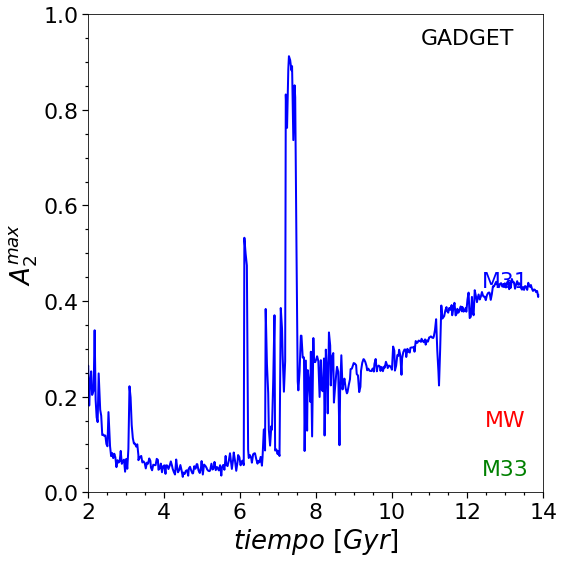

In [4]:
#Grafico de time vs A2max (en 2r50)
#t, A2max, krot, Mgal, Mgas, Mvir
import matplotlib.pyplot as plt

vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

for i in range(0,1):
    cm=np.loadtxt('/home/ornela/python/sem2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    A2max=cm[:,4]
    
    time =[]
    A2=[]
    aux=range(0,447,1)
    for j in aux:
        time.append(t[j])
        A2.append(A2max[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,A2,'k', color = '%s'%vec2[i], lw=2)
    ax0.set_ylim(0,1)
    ax0.set_xlim(2,14)
    ax0.set_xlabel(u'$tiempo$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$A_{2}^{max}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')

plt.text(x=12 , y=0.95 , s = 'GADGET',color ='k',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=0.42 , s = 'M31',color ='blue',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=0.13 , s = 'MW',color ='red',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=0.07 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
#fig.savefig('/home/ornela/Materias/trabajo_final/mi_tesis/Figures/GD_time_vs_A2max.png', dpi = 100)
plt.show()

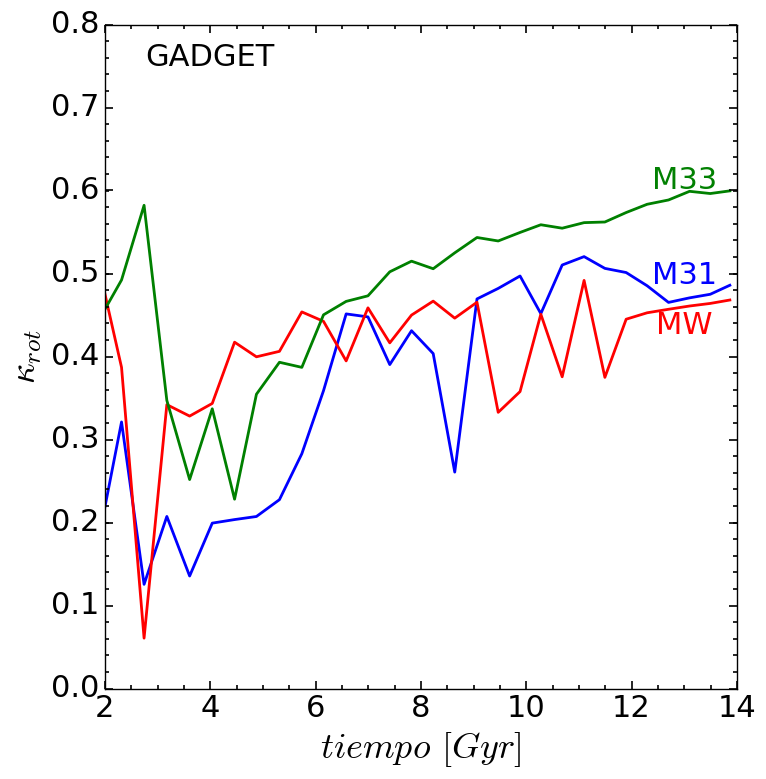

In [4]:
# Grafico de time vs krot
#t, A2max, krot, Mgal, Mgas, Mvir
import matplotlib.pyplot as plt

vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

for i in range(0,3):
    cm=np.loadtxt('/home/ornela/python/sem2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    krot =cm[:,5]
    
    time =[]
    kk=[]
    aux=range(0,447,15)
    for j in aux:
        time.append(t[j])
        kk.append(krot[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,kk,'k', lw=2, color = '%s'%vec2[i])
    ax0.set_ylim(0,0.8)
    ax0.set_xlim(2,14)   
    ax0.set_xlabel(u'$tiempo$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$\kappa_{rot}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')
    
plt.text(x=4 , y=0.76 , s = 'GADGET',color ='k',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=0.48 , s = 'M31',color ='blue',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=0.42 , s = 'MW',color ='red',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=0.63 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
fig.savefig('/home/ornela/Materias/trabajo_final/mi_tesis/Figures/GD_time_vs_krot.png', dpi = 100)
plt.show()
    
    

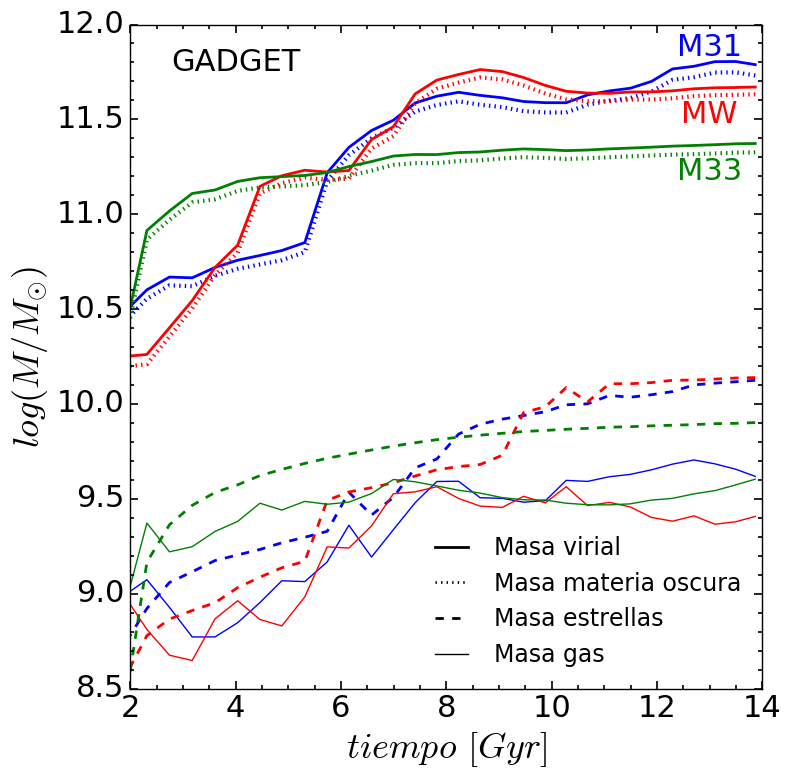

In [3]:
# Grafico de time vs Mgal
#t, A2max, krot, Mgal, Mgas
import matplotlib.pyplot as plt

vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')
vector3=('M31', 'MW', 'M33')
j=0
 
for i in range(0,3):

    cm=np.loadtxt('/home/ornela/python/sem2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    Mgal=cm[:,6]
    Mgas=cm[:,7]
    Mvir=cm[:,8]
    Mdrk=cm[:,9]
    
    time =[]
    m_gal=[]
    m_gas=[]
    m_vir=[]
    m_drk=[]
    aux=range(0,447,15)
    for j in aux:
        time.append(t[j])
        m_gal.append(Mgal[j])
        m_gas.append(Mgas[j])
        m_vir.append(Mvir[j])
        m_drk.append(Mdrk[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,m_gal,'--', lw=2, color = '%s'%vec2[i], label= 'Masa estrellas')
    ax0.plot(time,m_gas,'k', lw=1, color = '%s'%vec2[i], label = 'Masa gas')
    ax0.plot(time,m_drk,':', lw=3, color = '%s'%vec2[i], label='Masa materia oscura')
    ax0.plot(time,m_vir,'k', lw=2, color = '%s'%vec2[i], label='Masa virial')
    ax0.set_ylim(8.5,12)
    ax0.set_xlim(2,14)
    ax0.set_xlabel(u'$tiempo$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$log(M/M_{\odot})$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')
    
handles, labels = ax0.get_legend_handles_labels()
#Create custom artists
Estrellas = plt.Line2D((0,1),(0,0), color='k', linestyle='--',lw=2)
Gas = plt.Line2D((0,1),(0,0), color='k', linestyle='-', lw=1)
M_oscura = plt.Line2D((0,1),(0,0), color='k',  linestyle=':', lw=2)
M_virial = plt.Line2D((0,1),(0,0), color='k',  linestyle='-', lw=2)
#Create legend from custom artist/label lists
ax0.legend([M_virial, M_oscura, Estrellas, Gas],['Masa virial','Masa materia oscura','Masa estrellas', 'Masa gas'],
           fontsize=17, frameon=False, loc=4, numpoints=4)

    
plt.text(x=4 , y=11.8 , s = 'GADGET',color ='k',fontsize = 22, va = 'center', ha = 'center')

#plt.text(x=3 , y=11.4 , s = '$Masa\:virial$',color ='k',fontsize = 22, va = 'center', ha = 'left')
#plt.text(x=8.5 , y=10 , s = 'M31',color ='blue',fontsize = 22, va = 'center', ha = 'center',rotation= 15)
#plt.text(x=11 , y=10.1 , s = 'MW',color ='red',fontsize = 22, va = 'bottom', ha = 'center')
#plt.text(x=4 , y=9.8 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center',rotation= 15)

#plt.text(x=3 , y=9.9 , s = '$Masa\:estelar$',color ='k',fontsize = 22, va = 'center', ha = 'left')
plt.text(x=13 , y=11.8 , s = 'M31',color ='blue',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=11.6 , s = 'MW',color ='red',fontsize = 22, va = 'top', ha = 'center')
plt.text(x=13 , y=11.3 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
fig.savefig('/home/ornela/Materias/trabajo_final/mi_tesis/Figures/GD_time_vs_Mgal-vir.png', dpi = 100)
plt.show()
    

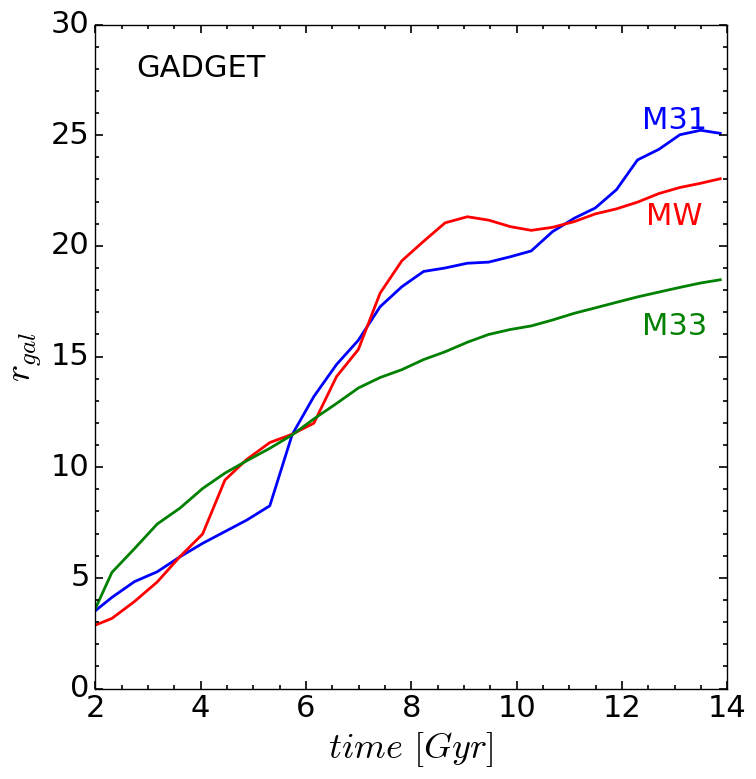

In [2]:
# Grafico de time vs krot
#t, A2max, krot, Mgal, Mgas, Mvir
import matplotlib.pyplot as plt

vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

for i in range(0,3):
    cm=np.loadtxt('/home/ornela/python/sem2/A2-krot-s'+'%s' %vector[i]+'.dat')
     
    t=cm[:,0]
    rgal =cm[:,2]
    
    time =[]
    r_gal=[]
    aux=range(0,447,15)
    for j in aux:
        time.append(t[j])
        r_gal.append(rgal[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,r_gal,'k', lw=2, color = '%s'%vec2[i])
    #ax0.set_ylim(0,0.7)
    ax0.set_xlim(2,14)
    ax0.set_xlabel(u'$time$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$r_{gal}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')
    
plt.text(x=4 , y=28 , s = 'GADGET',color ='k',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=25 , s = 'M31',color ='blue',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=22 , s = 'MW',color ='red',fontsize = 22, va = 'top', ha = 'center')
plt.text(x=13 , y=17 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
#fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_time_vs_rgal.png', dpi = 100)
plt.show()

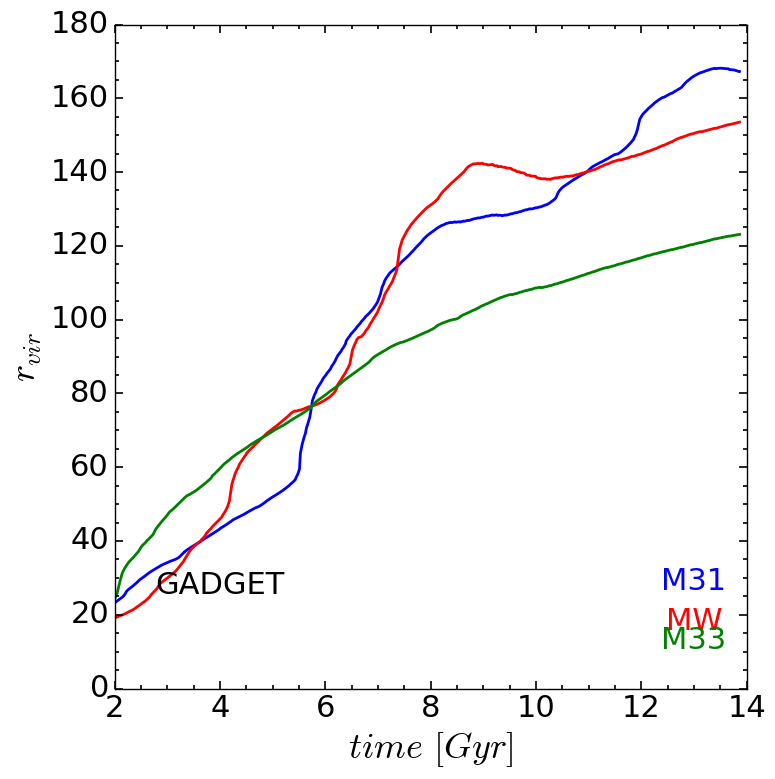

In [3]:
# Grafico de time vs krot
#t, A2max, krot, Mgal, Mgas, Mvir
import matplotlib.pyplot as plt

vector = ('00','01','03')
vec2 = ('blue', 'red', 'green')

for i in range(0,3):
    cm=np.loadtxt('/home/ornela/python/sem2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    rvir =cm[:,3]
    
    time =[]
    r_vir=[]
    aux=range(0,len(t),1)
    for j in aux:
        time.append(t[j])
        r_vir.append(rvir[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,r_vir,'k', lw=2, color = '%s'%vec2[i])
    #ax0.set_ylim(0,0.7)
    ax0.set_xlim(2,14)
    ax0.set_xlabel(u'$time$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$r_{vir}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')
    
plt.text(x=4 , y=28 , s = 'GADGET',color ='k',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=25 , s = 'M31',color ='blue',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=22 , s = 'MW',color ='red',fontsize = 22, va = 'top', ha = 'center')
plt.text(x=13 , y=17 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
#fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_time_vs_rgal.png', dpi = 100)
plt.show()